In [1]:
from sdkgenerator.generate import generate_sdk
from sdkgenerator.constants import DATA_DIR, GENERATED_SDK_DIR
from sdkgenerator.utils import get_code_from_model_response
from sdkgenerator.db import db
import pandas as pd
from pathlib import Path
import os

Database connected successfully. (MongoDB)


In [2]:
TEST_DATA_DIR = DATA_DIR / "test"
TEST_DATA_DIR.mkdir(exist_ok=True)
SPECIFICATIONS_DIR = DATA_DIR / "openapi-specifications"
GPT_GENERATED_SDKS_DIR = Path(os.getcwd()) / "gpt_generated_sdks"

## Query testing data

In [3]:
sdk_code_test_data_pipeline = [
    {"$match": {"step": "final_code", "response.openai.status": "success"}},
    {
        "$sort": {"_id": 1}
    },  # Sort by _id to sort by insertion date (I accidentally added multiple final_code for some data)
    {
        "$group": {
            "_id": "$sdk_name",
            "last_response_text": {"$last": "$response.openai.generated_text"},
        }
    },
    {"$project": {"sdk_name": "$_id", "last_response_text": 1, "_id": 0}},
]

data = list(db["eval"].aggregate(sdk_code_test_data_pipeline))
df_test_data = pd.DataFrame(data)
df_test_data.head()

,last_response_text,sdk_name
0,```python\nimport requests\n\nclass AdatreeCli...,adatree_data
1,```python\nimport requests\nfrom types import ...,baseten
2,```python\nimport requests\nfrom typing import...,flickr
3,```python\nimport requests\nfrom types import ...,milefy
4,```python\nimport requests\nfrom urllib.parse ...,foodkit


we need to extract the code from the generated text

In [4]:
df_test_data["sdk_code"] = df_test_data["last_response_text"].apply(
    lambda x: get_code_from_model_response(x)[0]
)
df_test_data = df_test_data.drop(columns=["last_response_text"])
df_test_data.head()

,sdk_name,sdk_code
0,adatree_data,import requests\n\nclass AdatreeClient:\n d...
1,baseten,import requests\nfrom types import UpsertSecre...
2,flickr,"import requests\nfrom typing import Optional, ..."
3,milefy,import requests\nfrom types import *\n\nclass ...
4,foodkit,import requests\nfrom urllib.parse import urlj...


In [5]:
# remove rows with None
df_test_data = df_test_data.dropna()
df_test_data.head()

,sdk_name,sdk_code
0,adatree_data,import requests\n\nclass AdatreeClient:\n d...
1,baseten,import requests\nfrom types import UpsertSecre...
2,flickr,"import requests\nfrom typing import Optional, ..."
3,milefy,import requests\nfrom types import *\n\nclass ...
4,foodkit,import requests\nfrom urllib.parse import urlj...


In [6]:
types_code_test_data_pipeline = [
    {"$match": {"step": "types", "response.openai.status": "success"}},
    {
        "$sort": {"_id": 1}
    },  # Sort by _id to sort by insertion date (I accidentally added multiple final_code for some data)
    {
        "$group": {
            "_id": "$sdk_name",
            "last_response_text": {"$last": "$response.openai.generated_text"},
        }
    },
    {"$project": {"sdk_name": "$_id", "last_response_text": 1, "_id": 0}},
]

data = list(db["eval"].aggregate(types_code_test_data_pipeline))
df_types = pd.DataFrame(data)
df_types["types_code"] = df_types["last_response_text"].apply(
    lambda x: get_code_from_model_response(x)[0]
)
df_types.drop(columns=["last_response_text"], inplace=True)
df_types.head()

,sdk_name,types_code
0,fastspring,"from typing import TypedDict, List, Literal, O..."
1,types,"from typing import List, TypedDict, Union, Lit..."
2,bluesnap,"from typing import TypedDict, List, Literal, U..."
3,milefy,"from typing import List, TypedDict, Union, Lit..."
4,dev,"from typing import TypedDict, Optional, Litera..."


In [7]:
# merge the two dataframes if sdk has no types set types_code to empty string
df_test_data = df_test_data.merge(df_types, on="sdk_name", how="left")
df_test_data.fillna("", inplace=True)


df_test_data.head()

,sdk_name,sdk_code,types_code
0,adatree_data,import requests\n\nclass AdatreeClient:\n d...,"from typing import TypedDict, List, Literal, O..."
1,baseten,import requests\nfrom types import UpsertSecre...,"from typing import TypedDict, Optional\n\nclas..."
2,flickr,"import requests\nfrom typing import Optional, ...",
3,milefy,import requests\nfrom types import *\n\nclass ...,"from typing import List, TypedDict, Union, Lit..."
4,foodkit,import requests\nfrom urllib.parse import urlj...,"from typing import TypedDict, Literal, List\n\..."


In [8]:
def merge_code(sdk_code: str, types_code: str) -> str:
    if types_code:
        return types_code + "\n" + "-" * 10 + "\n" + sdk_code
    return sdk_code

In [9]:
# answer is sdk_code + types_code
df_test_data["answer"] = df_test_data.apply(
    lambda x: merge_code(x["sdk_code"], x["types_code"]), axis=1
)

df_test_data.head()

,sdk_name,sdk_code,types_code,answer
0,adatree_data,import requests\n\nclass AdatreeClient:\n d...,"from typing import TypedDict, List, Literal, O...","from typing import TypedDict, List, Literal, O..."
1,baseten,import requests\nfrom types import UpsertSecre...,"from typing import TypedDict, Optional\n\nclas...","from typing import TypedDict, Optional\n\nclas..."
2,flickr,"import requests\nfrom typing import Optional, ...",,"import requests\nfrom typing import Optional, ..."
3,milefy,import requests\nfrom types import *\n\nclass ...,"from typing import List, TypedDict, Union, Lit...","from typing import List, TypedDict, Union, Lit..."
4,foodkit,import requests\nfrom urllib.parse import urlj...,"from typing import TypedDict, Literal, List\n\...","from typing import TypedDict, Literal, List\n\..."


now we get the generated code for each sdk

In [10]:
df_test_data.drop(columns=["sdk_code", "types_code"], inplace=True)
df_test_data.head()

,sdk_name,answer
0,adatree_data,"from typing import TypedDict, List, Literal, O..."
1,baseten,"from typing import TypedDict, Optional\n\nclas..."
2,flickr,"import requests\nfrom typing import Optional, ..."
3,milefy,"from typing import List, TypedDict, Union, Lit..."
4,foodkit,"from typing import TypedDict, Literal, List\n\..."


In [11]:
# fine_tuned_responses_pipeline = [
#     {
#         "$match": {
#             "payload.model": "ft:gpt-3.5-turbo-0125:eden-ai::9UxoYDO3",
#             "step": "final_code",
#             "response.choices": {
#                 "$size": 1
#             },
#             "response.choices.0.finish_reason": "stop"
#         }
#     },
#     {
#         "$sort": {
#             "_id": 1
#         }
#     },
#     {
#         "$group": {
#             "_id": "$sdk_name",
#             "last_document": { "$last": "$$ROOT" }
#         }
#     },
#     {
#         "$replaceRoot": { "newRoot": "$last_document" }
#     },
#     {
#         "$project": {
#             "_id": 0,
#             "sdk_name": 1,
#             "last_response_text": { "$arrayElemAt": ["$response.choices.message.content", 0] }
#         }
#     }
# ]
# fine_tuned_responses = list(db['responses'].aggregate(fine_tuned_responses_pipeline))
#
# fine_tuned_responses = pd.DataFrame(fine_tuned_responses)
# fine_tuned_responses

In [12]:
user_rules = "1. Use the requests library: All HTTP requests within the SDK must be made using the 'requests' library.\n2. Class structure: The SDK must be a class, with each method representing an endpoint in the API. Choose method names that reflect the action or resource they interact with.\n3. Authenticated requests: Implement a method '_make_authenticated_request' to handle authenticated requests.\n4. JSON request body: Use JSON format for the body of all requests.\n5. Return type: All methods must return the 'Response' object from the 'requests' library."


def get_generated_code(sdk_name):
    try:
        sdk_name_path = GENERATED_SDK_DIR / sdk_name / f"{sdk_name}.py"
        types_code_path = GENERATED_SDK_DIR / sdk_name / f"types.py"
        sdk_code = sdk_name_path.read_text()
        types_code = types_code_path.read_text() if types_code_path.exists() else ""
        return merge_code(sdk_code, types_code)
    except FileNotFoundError:
        print(f"Generating SDK for {sdk_name}")
        spec_path = None
        for file in SPECIFICATIONS_DIR.iterdir():
            if sdk_name in file.name:
                spec_path = file
                break
        if spec_path is None:
            raise Exception(f"Specification file for {sdk_name} not found")
        try:
            _, sdk_output_file, types_output_file = generate_sdk(
                spec_path, user_rules=user_rules
            )
        except Exception as e:
            print(f"Error generating SDK for {sdk_name}: {e}")
            return None
        if sdk_output_file is None:
            return None
        sdk_code = sdk_output_file.read_text()
        types_code = types_output_file.read_text() if types_output_file else ""

        return merge_code(sdk_code, types_code)


df_test_data["llm_answer"] = df_test_data["sdk_name"].apply(get_generated_code)

In [13]:
df_test_data.head()

,sdk_name,answer,llm_answer
0,adatree_data,"from typing import TypedDict, List, Literal, O...","from typing import TypedDict, List, Literal\n\..."
1,baseten,"from typing import TypedDict, Optional\n\nclas...","from typing import TypedDict, Optional\n\n\ncl..."
2,flickr,"import requests\nfrom typing import Optional, ...","import requests\nfrom typing import Optional, ..."
3,milefy,"from typing import List, TypedDict, Union, Lit...","from typing import List, TypedDict, Literal\nf..."
4,foodkit,"from typing import TypedDict, Literal, List\n\...","from typing import TypedDict, Literal, List\n\..."


## Get ChatGPT generated code

In [14]:
def get_chatgpt_generated_sdks():
    chatgpt_generated_sdks = {}
    for sdk_dir in GPT_GENERATED_SDKS_DIR.iterdir():
        sdk_name = sdk_dir.name
        sdk_code = (sdk_dir / f"{sdk_name}.py").read_text()
        types_code = (
            (sdk_dir / "types.py").read_text()
            if (sdk_dir / "types.py").exists()
            else ""
        )
        chatgpt_generated_sdks[sdk_name] = merge_code(sdk_code, types_code)

    return chatgpt_generated_sdks


chatgpt_sdks_df = pd.DataFrame(
    get_chatgpt_generated_sdks().items(), columns=["sdk_name", "chatgpt_generated_code"]
)
chatgpt_sdks_df.head()

,sdk_name,chatgpt_generated_code
0,1-password_connect,"from typing import TypedDict, NotRequired, Lit..."
1,2-c-2-p,"from typing import TypedDict, Optional, List, ..."
2,adatree_banking,import requests\n\n\nclass APIClient:\n def...
3,adatree_consent,"from typing import TypedDict, Literal, Union, ..."
4,affinity,import requests\n\n\nclass AffinityAPIClient:\...


## Get Answers for ChatGPT generated code

In [15]:
chatgpt_sdks_df["answer"] = chatgpt_sdks_df["sdk_name"].apply(
    lambda x: df_test_data[df_test_data["sdk_name"] == x]["answer"].values[0]
)
chatgpt_sdks_df.head()

,sdk_name,chatgpt_generated_code,answer
0,1-password_connect,"from typing import TypedDict, NotRequired, Lit...","from typing import TypedDict, List, Union, Lit..."
1,2-c-2-p,"from typing import TypedDict, Optional, List, ...","from typing import TypedDict, Optional, List, ..."
2,adatree_banking,import requests\n\n\nclass APIClient:\n def...,import requests\nimport json\nfrom typing impo...
3,adatree_consent,"from typing import TypedDict, Literal, Union, ...","from typing import TypedDict, Literal, Optiona..."
4,affinity,import requests\n\n\nclass AffinityAPIClient:\...,import json\nimport requests\n\nclass Affinity...


# Evaluation

In [16]:
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
from codebleu import calc_codebleu
from sdkgenerator.types import Language
from sdkgenerator.config import AGENT

## BLEU Score

In [17]:
def calculate_bleu_score(machine_results, reference_texts):
    return corpus_bleu(
        [[ref.split()] for ref in reference_texts],
        [gen.split() for gen in machine_results],
    )

In [18]:
bleu_score = calculate_bleu_score(df_test_data["llm_answer"], df_test_data["answer"])
gpt_blue_score = calculate_bleu_score(
    chatgpt_sdks_df["chatgpt_generated_code"], chatgpt_sdks_df["answer"]
)
bleu_score, gpt_blue_score

(0.6613585145955119, 0.12273377476807674)

## ROUGE Score

In [19]:
def calculate_rouge_score(machine_results, reference_texts):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    scores = [
        scorer.score(ref, gen) for ref, gen in zip(reference_texts, machine_results)
    ]
    rouge1 = sum(score["rouge1"].fmeasure for score in scores) / len(scores)
    rouge2 = sum(score["rouge2"].fmeasure for score in scores) / len(scores)
    rougeL = sum(score["rougeL"].fmeasure for score in scores) / len(scores)
    return {"rouge1": rouge1, "rouge2": rouge2, "rougeL": rougeL}

In [20]:
rouge_score = calculate_rouge_score(df_test_data["llm_answer"], df_test_data["answer"])
gpt_rouge_score = calculate_rouge_score(
    chatgpt_sdks_df["chatgpt_generated_code"], chatgpt_sdks_df["answer"]
)
rouge_score, gpt_rouge_score

({'rouge1': 0.913606836349474,
  'rouge2': 0.8757805708282291,
  'rougeL': 0.8912410022746832},
 {'rouge1': 0.5489451398277451,
  'rouge2': 0.35441656174138353,
  'rougeL': 0.48240295208300066})

## Code BLEU Score

In [21]:
def calculate_code_bleu(machine_results, reference_texts, lang: Language):
    return calc_codebleu(reference_texts, machine_results, lang=lang)

In [22]:
code_bleu_score = calculate_code_bleu(
    df_test_data["llm_answer"], df_test_data["answer"], "python"
)
gpt_code_bleu_score = calculate_code_bleu(
    chatgpt_sdks_df["chatgpt_generated_code"], chatgpt_sdks_df["answer"], "python"
)
code_bleu_score, gpt_code_bleu_score

({'codebleu': 0.8056921519460951,
  'ngram_match_score': 0.6613585145955119,
  'weighted_ngram_match_score': 0.7445710734287818,
  'syntax_match_score': 0.9552276453525035,
  'dataflow_match_score': 0.861611374407583},
 {'codebleu': 0.2945107012977473,
  'ngram_match_score': 0.12273377476807674,
  'weighted_ngram_match_score': 0.13959846895992395,
  'syntax_match_score': 0.6749338624338624,
  'dataflow_match_score': 0.2407766990291262})

In [23]:
all_scores = {
    AGENT["final_code"]["model"]: {
        "bleu": bleu_score,
        **rouge_score,
        **code_bleu_score,
    },
    "GPT-3.5-turbo": {"bleu": gpt_blue_score, **gpt_rouge_score, **gpt_code_bleu_score},
}

evaluation = pd.DataFrame(all_scores)
evaluation

,ft:gpt-3.5-turbo-0125:eden-ai::9UxoYDO3,GPT-3.5-turbo
bleu,0.661359,0.122734
rouge1,0.913607,0.548945
rouge2,0.875781,0.354417
rougeL,0.891241,0.482403
codebleu,0.805692,0.294511
ngram_match_score,0.661359,0.122734
weighted_ngram_match_score,0.744571,0.139598
syntax_match_score,0.955228,0.674934
dataflow_match_score,0.861611,0.240777


# Save evaluation

In [24]:
evaluation.to_csv(TEST_DATA_DIR / "evaluation.csv", index=False)

# Human Evaluation

Let's compare the generated code with the answer and see if it is correct

In [25]:
from pprint import pprint

In [26]:
df_test_data["sdk_name"].values

array(['adatree_data', 'baseten', 'flickr', 'milefy', 'foodkit', 'bity',
       '2-c-2-p', 'adatree_banking', 'adatree_consent', 'affinity',
       'finley', 'bluesnap', '1-password_connect', 'apaleo'], dtype=object)

In [27]:
current_sdk_name = "affinity"
generated_code = get_generated_code(current_sdk_name)
gpt_generated_code = chatgpt_sdks_df[chatgpt_sdks_df["sdk_name"] == current_sdk_name][
    "chatgpt_generated_code"
].values[0]
answer = df_test_data[df_test_data["sdk_name"] == current_sdk_name]["answer"].values[0]

In [28]:
pprint(generated_code)

('import requests\n'
 '\n'
 '\n'
 'class AffinityClient:\n'
 '    def __init__(self, api_key):\n'
 '        self.api_key = api_key\n'
 '        self.base_url = "https://api.affinity.co"\n'
 '\n'
 '    def _make_authenticated_request(self, method, url, **kwargs):\n'
 '        headers = {\n'
 '            "Authorization": f"Bearer {self.api_key}",\n'
 '            "Content-Type": "application/json",\n'
 '        }\n'
 '        response = requests.request(method, url, headers=headers, **kwargs)\n'
 '        if response.status_code != 200:\n'
 '            raise Exception(f"Request failed with status code '
 '{response.status_code}")\n'
 '        return response\n'
 '\n'
 '    def get_current_user(self):\n'
 '        """Retrieve the current user\'s information."""\n'
 '        url = f"{self.base_url}/v2/auth/whoami"\n'
 '        return self._make_authenticated_request("GET", url)\n'
 '\n'
 '    def get_all_companies(self, query_params=None):\n'
 '        """Retrieve all companies with opti

In [29]:
pprint(answer)

('import json\n'
 'import requests\n'
 '\n'
 'class AffinityClient:\n'
 '    def __init__(self, api_key):\n'
 '        self.api_key = api_key\n'
 '        self.base_url = "https://api.affinity.co"\n'
 '\n'
 '    def _make_authenticated_request(self, method, url, **kwargs):\n'
 '        headers = {\n'
 '            "Authorization": f"Bearer {self.api_key}",\n'
 '            "Content-Type": "application/json"\n'
 '        }\n'
 '        response = requests.request(method, url, headers=headers, **kwargs)\n'
 '        if response.status_code != 200:\n'
 '            raise Exception(f"Request failed with status code '
 '{response.status_code}")\n'
 '        return response\n'
 '\n'
 '    def get_current_user(self):\n'
 '        """Retrieve the current user\'s information."""\n'
 '        url = f"{self.base_url}/v2/auth/whoami"\n'
 '        return self._make_authenticated_request("GET", url)\n'
 '\n'
 '    def get_all_companies(self, query_params=None):\n'
 '        """Retrieve all companies

In [30]:
pprint(gpt_generated_code)

('import requests\n'
 '\n'
 '\n'
 'class AffinityAPIClient:\n'
 '    def __init__(self, base_url: str, api_key: str):\n'
 '        self.base_url = base_url\n'
 '        self.api_key = api_key\n'
 '\n'
 '    def _make_authenticated_request(self, method: str, path: str, params: '
 'dict = None):\n'
 '        url = f"{self.base_url}{path}"\n'
 '        headers = {\n'
 '            "Authorization": f"Bearer {self.api_key}",\n'
 '            "Content-Type": "application/json",\n'
 '        }\n'
 '        response = requests.request(method, url, headers=headers, '
 'params=params)\n'
 '        return response\n'
 '\n'
 '    def Auth_getCurrentUser(self):\n'
 '        return self._make_authenticated_request("GET", "/v2/auth/whoami")\n'
 '\n'
 '    def Companies_getAll(\n'
 '        self,\n'
 '        cursor: str = None,\n'
 '        limit: int = 100,\n'
 '        ids: list[int] = None,\n'
 '        fieldIds: list[str] = None,\n'
 '        fieldTypes: list[str] = None,\n'
 '    ):\n'
 '       

## compare the generated code with the answer

In [31]:
from difflib import unified_diff

In [32]:
# compare the generated code with the gpt generated code
diff = list(
    unified_diff(answer.splitlines(), gpt_generated_code.splitlines(), lineterm="")
)
diff

['--- ',
 '+++ ',
 '@@ -1,117 +1,159 @@',
 '-import json',
 ' import requests',
 ' ',
 '-class AffinityClient:',
 '-    def __init__(self, api_key):',
 '+',
 '+class AffinityAPIClient:',
 '+    def __init__(self, base_url: str, api_key: str):',
 '+        self.base_url = base_url',
 '         self.api_key = api_key',
 '-        self.base_url = "https://api.affinity.co"',
 ' ',
 '-    def _make_authenticated_request(self, method, url, **kwargs):',
 '+    def _make_authenticated_request(self, method: str, path: str, params: dict = None):',
 '+        url = f"{self.base_url}{path}"',
 '         headers = {',
 '             "Authorization": f"Bearer {self.api_key}",',
 '-            "Content-Type": "application/json"',
 '+            "Content-Type": "application/json",',
 '         }',
 '-        response = requests.request(method, url, headers=headers, **kwargs)',
 '-        if response.status_code != 200:',
 '-            raise Exception(f"Request failed with status code {response.status

# Plotting

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [34]:
evaluation_df = evaluation.T
evaluation_df.reset_index(inplace=True)
evaluation_df

,index,bleu,rouge1,rouge2,rougeL,codebleu,ngram_match_score,weighted_ngram_match_score,syntax_match_score,dataflow_match_score
0,ft:gpt-3.5-turbo-0125:eden-ai::9UxoYDO3,0.661359,0.913607,0.875781,0.891241,0.805692,0.661359,0.744571,0.955228,0.861611
1,GPT-3.5-turbo,0.122734,0.548945,0.354417,0.482403,0.294511,0.122734,0.139598,0.674934,0.240777


In [35]:
evaluation_df.rename(columns={"index": "model"}, inplace=True)
evaluation_df

,model,bleu,rouge1,rouge2,rougeL,codebleu,ngram_match_score,weighted_ngram_match_score,syntax_match_score,dataflow_match_score
0,ft:gpt-3.5-turbo-0125:eden-ai::9UxoYDO3,0.661359,0.913607,0.875781,0.891241,0.805692,0.661359,0.744571,0.955228,0.861611
1,GPT-3.5-turbo,0.122734,0.548945,0.354417,0.482403,0.294511,0.122734,0.139598,0.674934,0.240777


In [36]:
evaluation_df = evaluation_df.melt(
    id_vars="model", var_name="metric", value_name="score"
)
evaluation_df

,model,metric,score
0,ft:gpt-3.5-turbo-0125:eden-ai::9UxoYDO3,bleu,0.661359
1,GPT-3.5-turbo,bleu,0.122734
2,ft:gpt-3.5-turbo-0125:eden-ai::9UxoYDO3,rouge1,0.913607
3,GPT-3.5-turbo,rouge1,0.548945
4,ft:gpt-3.5-turbo-0125:eden-ai::9UxoYDO3,rouge2,0.875781
5,GPT-3.5-turbo,rouge2,0.354417
6,ft:gpt-3.5-turbo-0125:eden-ai::9UxoYDO3,rougeL,0.891241
7,GPT-3.5-turbo,rougeL,0.482403
8,ft:gpt-3.5-turbo-0125:eden-ai::9UxoYDO3,codebleu,0.805692
9,GPT-3.5-turbo,codebleu,0.294511


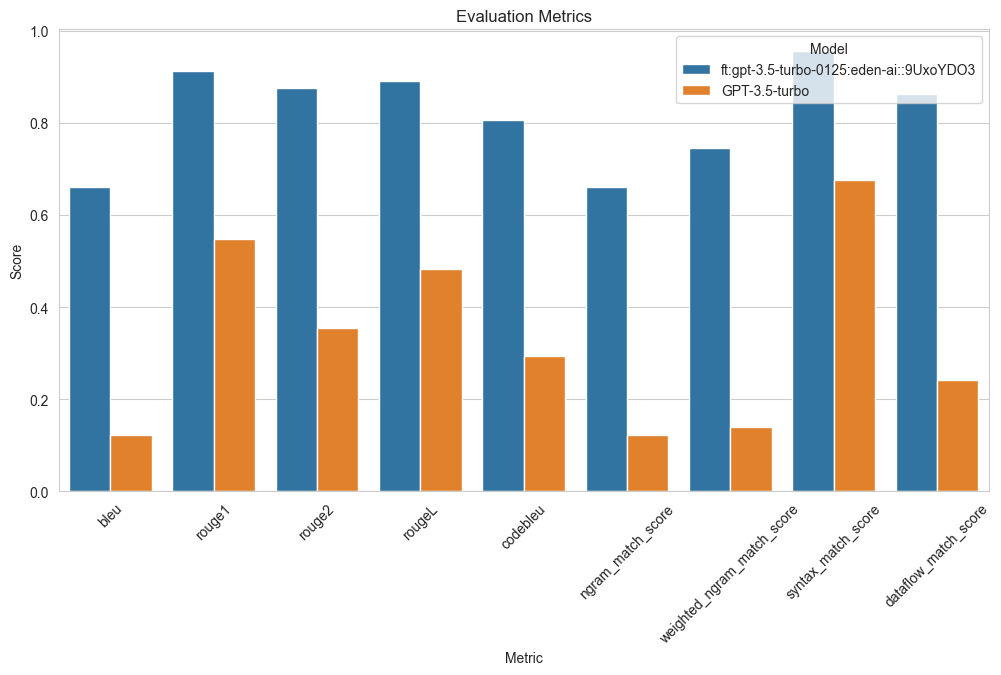

In [37]:
plt.figure(figsize=(12, 6))
sns.barplot(x="metric", y="score", hue="model", data=evaluation_df)
plt.title("Evaluation Metrics")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(title="Model", loc="upper right")
plt.xticks(rotation=45)
# save plot
plt.savefig(TEST_DATA_DIR / "evaluation_plot.png")

we can see that our fine-tuned model outperforms GPT-3.5-turbo in all metrics

# Tokenization with and without preprocessing and splitting

In [38]:
import tiktoken
from sdkgenerator.config import AGENT
from sdkgenerator.manifier import get_api_data

In [39]:
tokenizer = tiktoken.encoding_for_model(AGENT["final_code"]["model"])
tokens_dict = {}
for sdk_name in df_test_data["sdk_name"].values:
    openapi_specification = SPECIFICATIONS_DIR / f"{sdk_name}.yaml"
    content_without_preprocessing = openapi_specification.read_text()
    tokens_without_preprocessing = tokenizer.encode(content_without_preprocessing)
    specs, types = get_api_data(openapi_specification)
    content_with_preprocessing = specs + str(types)
    tokens_with_preprocessing = tokenizer.encode(content_with_preprocessing)
    tokens_dict[sdk_name] = {
        "tokens_without_preprocessing": len(tokens_without_preprocessing),
        "tokens_with_preprocessing": len(tokens_with_preprocessing),
    }

tokens_df = pd.DataFrame(tokens_dict).T
tokens_df

,tokens_without_preprocessing,tokens_with_preprocessing
adatree_data,54170,3535
baseten,4731,1121
flickr,11915,2939
milefy,24229,1944
foodkit,32131,3785
bity,16268,2854
2-c-2-p,11790,2573
adatree_banking,32447,3161
adatree_consent,10213,1811
affinity,28319,2569


# Plotting tokenization data

In [40]:
tokens_df.reset_index(inplace=True)
tokens_df.rename(columns={"index": "sdk_name"}, inplace=True)
# save data
tokens_df.to_csv(TEST_DATA_DIR / "tokenization_data.csv", index=False)
tokens_df

,sdk_name,tokens_without_preprocessing,tokens_with_preprocessing
0,adatree_data,54170,3535
1,baseten,4731,1121
2,flickr,11915,2939
3,milefy,24229,1944
4,foodkit,32131,3785
5,bity,16268,2854
6,2-c-2-p,11790,2573
7,adatree_banking,32447,3161
8,adatree_consent,10213,1811
9,affinity,28319,2569


In [41]:
tokens_df = tokens_df.melt(
    id_vars="sdk_name",
    var_name="preprocessing",
    value_name="tokens",
)

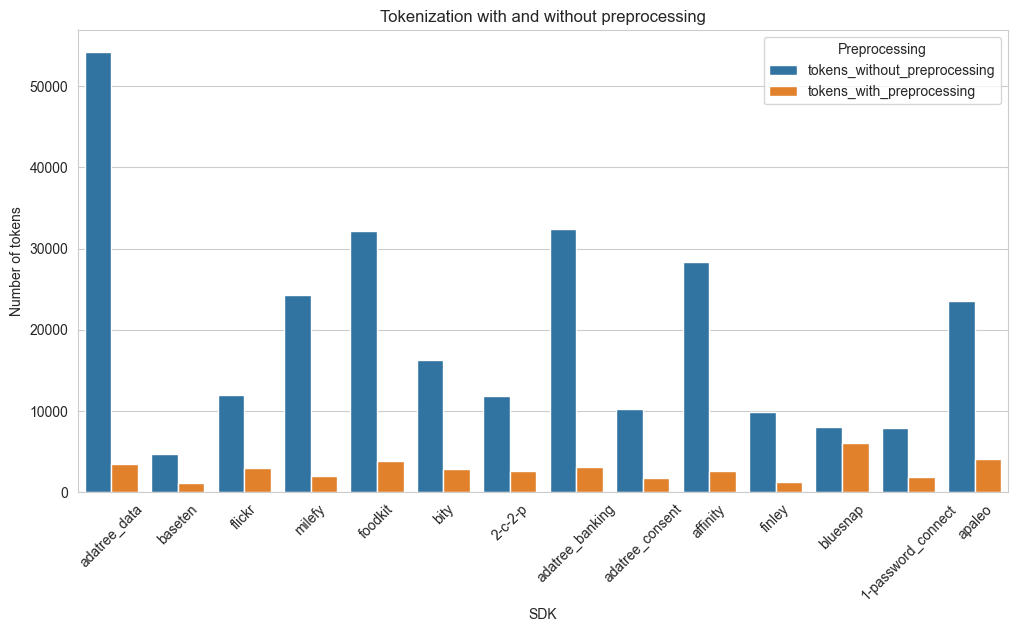

In [42]:
plt.figure(figsize=(12, 6))
sns.barplot(x="sdk_name", y="tokens", hue="preprocessing", data=tokens_df)

plt.title("Tokenization with and without preprocessing")
plt.ylabel("Number of tokens")
plt.xlabel("SDK")
plt.xticks(rotation=45)
plt.legend(title="Preprocessing", loc="upper right")

# save plot
plt.savefig(TEST_DATA_DIR / "tokenization_plot.png")